# Code

## 1: Spotify API
This part takes care of the contact with Spotifys web API, both authorization and searches.

In [15]:
# Libraries
import base64
import datetime
import requests
from urllib.parse import urlencode

In [16]:
class SpotifyAPI(object):
    access_token = None
    access_token_expires = datetime.datetime.now()
    access_token_did_expire = True
    client_id = None
    client_secret = None
    token_url = "https://accounts.spotify.com/api/token"
    
    def __init__(self, client_id, client_secret,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.client_id = client_id
        self.client_secret = client_secret   
        
    def get_client_credentials(self):
        """
        Returns a base64 encoded string
        """
        client_id = self.client_id
        client_secret = self.client_secret
        if client_secret == None or client_id == None:
            raise Exception("You must set client_id and client_secret")
        client_creds = f"{client_id}:{client_secret}"
        client_creds_b64 = base64.b64encode(client_creds.encode())

        return client_creds_b64.decode()
        
    def get_token_headers(self):
        client_creds_b64 = self.get_client_credentials()
        
        return{
                "Authorization" : f"Basic {client_creds_b64}"            
                }

    def get_token_data(self):
        return{
               "grant_type" : "client_credentials" 
               }
        
    def perform_auth(self):     
        token_url = self.token_url
        token_data = self.get_token_data()
        token_headers = self.get_token_headers()
        r = requests.post(token_url, data=token_data, headers = token_headers)
         
        if r.status_code not in range(200,299):
             raise Exception("Could not authenticate client.")
        
        data = r.json()
        now = datetime.datetime.now()
        access_token = data["access_token"]
        expires_in = data["expires_in"]
        expires = now + datetime.timedelta(seconds=expires_in)
        self.access_token = access_token
        self.access_token_expires = expires
        self.access_token_did_expire = expires < now
        return True   
    
    def get_access_token(self):
        token = self.access_token
        expires = self.access_token_expires
        now = datetime.datetime.now()
        if expires < now:
            self.perform_auth()
            return self.get_access_token()
        elif token == None:
            self.perform_auth()
            return self.get_access_token()
        return token
    
    def get_resource_header(self):
        access_token = self.get_access_token()
        headers = {
            "Authorization": f"Bearer {access_token}"
            }
        return headers
    
    def get_resource(self, lookup_id, resource_type="albums", version="v1"):
        endpoint = f"https://api.spotify.com/{version}/{resource_type}/{lookup_id}"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()
    
    def get_album(self, _id):
        return self.get_resource(_id, resource_type="albums") 

    def get_artist(self, _id):
        return self.get_resource(_id, resource_type="artists") 

    def get_audio_features(self, _id):
        return self.get_resource(_id, resource_type="audio-features") 

    def get_track(self, _id):
        return self.get_resource(_id, resource_type="track") 
  
    def get_related_artists(self, lookup_id, resource_type="artists", version="v1"):
        endpoint = f"https://api.spotify.com/{version}/{resource_type}/{lookup_id}/related-artists"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()
    
    def get_artist_top_tracks(self, lookup_id, resource_type="artists", version="v1"):
        endpoint = f"https://api.spotify.com/{version}/{resource_type}/{lookup_id}/top-tracks?country=se"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()
    
    def base_search(self, query_params):
        headers = self.get_resource_header()
        endpoint = "https://api.spotify.com/v1/search"
        lookup_url = f"{endpoint}?{query_params}"
        r = requests.get(lookup_url, headers=headers)
        if r.status_code not in range(200,299):
            return {}
        return r.json()

    def search(self, query=None, operator = None, operator_query=None, search_type="artist"):
        if query==None:
            raise Exception("A query is required.")
        if isinstance(query, dict):
                   # letar genom alla key-value-par i dict och gör dem till str
            query = " ".join([f"{k}:{v}" for k,v in query.items()])
            
        if operator != None and operator_query != None:
            if operator == "or" or operator == "not":
                operator = operator.upper()
                if isinstance(operator_query,str):
                    query = f"{query} {operator} {operator_query}"
                
        query_params  = urlencode({"q": query, "type": search_type.lower()})
        #print(query_params)
 
        return self.base_search(query_params)


## 2: Functions
Functions used for creating dataframes of the information gathered from searches.

In [34]:
def related_artists_10(related_artists):
    related = []
    for k in range(10):    
        artist = {"Namn" : related_artists["artists"][k]["name"],
              "Genre": related_artists["artists"][k]["genres"],
              "Popularity":related_artists["artists"][k]["popularity"],
              "Id":related_artists["artists"][k]["id"],
              "Top_Songs": top_tracks(related_artists["artists"][k]["id"])
            }
        related.append(artist)
    return related 

def top_tracks(_id):
    rek1 = spotify.get_artist_top_tracks(_id)
    dvs = pd.DataFrame(columns={"Name","Popularity","Id",
                                "acousticness", "danceability","duration_ms", "energy",
                                "instrumentalness", "key", "liveness", "loudness", "mode", 
                                "speechiness","tempo","time_signature","valence"
                                }, index = range(len(rek1["tracks"])))
    for k in range(len(rek1["tracks"])):
        dvs["Name"][k] = rek1["tracks"][k]["name"]
        dvs["Popularity"][k] = rek1["tracks"][k]["popularity"]
        dvs["Id"][k] = rek1["tracks"][k]["id"]
        audio_features = spotify.get_audio_features(dvs["Id"][k])
        dvs["acousticness"][k] = audio_features["acousticness"]
        dvs["danceability"][k] = audio_features["danceability"]
        dvs["duration_ms"][k] = audio_features["duration_ms"]
        dvs["energy"][k] = audio_features["energy"]
        dvs["instrumentalness"][k] = audio_features["instrumentalness"]
        dvs["key"][k] = audio_features["key"]
        dvs["liveness"][k] = audio_features["liveness"]
        dvs["loudness"][k] = audio_features["loudness"]
        dvs["mode"][k] = audio_features["mode"]
        dvs["speechiness"][k] = audio_features["speechiness"]
        dvs["tempo"][k] = audio_features["tempo"]
        dvs["time_signature"][k] = audio_features["time_signature"]
        dvs["valence"][k] = audio_features["valence"]
        columns_order = ["Name","Id","Popularity",
                "acousticness", "danceability","duration_ms", "energy",
                "instrumentalness", "key", "liveness", "loudness", "mode", 
                "speechiness","tempo","time_signature","valence"]
        dvs=dvs.reindex(columns=columns_order)

    return dvs

def artist_id(song_name,artist_name):
    _id = spotify.search({"track": song_name,"artist": artist_name},
                           search_type ="track")["tracks"]["items"][0]["artists"][0]["id"]
    artist = [artist_name]
    artist.append(_id)
    
    return artist
    
def data_from_spotify(mest_lyssnade):  
    sample_list = []

    for k in range(len(mest_lyssnade)):
        start_artist = []
        related_artists = spotify.get_related_artists(mest_lyssnade.iloc[k,2])
        start_artist = related_artists_10(related_artists)
        sample_list.append(start_artist)


    sample = pd.DataFrame(columns=sample_list[0][0]["Top_Songs"].columns, index = range(1000))
    sample["Artist"] = np.nan
    sample["Genre"] = np.nan
    sample["Artist_Popularity"] = np.nan
   
    n = 0
    m = 0
    for i in range(len(sample_list)):
        n = 100 * i
        for k in range(10):
            m = 10 * k
            for j in range(10):    
                sample.iloc[n+m+j] = sample_list[i][k]["Top_Songs"].iloc[j]
                sample["Artist"][n+m+j] = sample_list[i][k]["Namn"]
                sample["Genre"][n+m+j] = sample_list[i][k]["Genre"]
                sample["Artist_Popularity"][n+m+j] = sample_list[i][k]["Popularity"]
        m = 0 

    return sample

def genres(potential_songs, listened_features, most_listened_songs):
    columns_order = ["Genre","Potential","Listened","Top"]
    potential_songs = potential_songs.reset_index(drop=True)
    listened_features = listened_features.reset_index(drop=True)
    most_listened_songs = most_listened_songs.reset_index(drop=True)
    
    genre_sum1 = pd.DataFrame(np.sum(potential_songs.Genre))[0].value_counts()
    genre_sum2 = pd.DataFrame(np.sum(listened_features.Genre))[0].value_counts()
    genre_sum3 = pd.DataFrame(np.sum(most_listened_songs.Genre))[0].value_counts()

    genre_sum = pd.DataFrame(columns={"Genre","Potential","Listened","Top"})
    genre_sum["Genre"] = genre_sum1.index
    genre_sum["Potential"] = genre_sum1.values
    for k in range(len(genre_sum2)):
        if genre_sum2.index[k] in genre_sum.Genre.values:
            contains = pd.DataFrame(genre_sum[genre_sum["Genre"].str.contains(genre_sum2.index[k], na=False)]["Genre"])
            contains["orig_ix"] = contains.index
            contains = contains.reset_index(drop=True)
            for i in range(len(contains)):
                if contains["Genre"][i] == genre_sum2.index[k]:
                    genre_sum["Listened"][contains["orig_ix"][i]] = genre_sum2[k]
                    break
        else: 
            append = pd.DataFrame(columns={"Genre","Potential","Listened","Top"}, index = range(1))
            append.iloc[0] = genre_sum2.index[k], 0, 0, genre_sum2[k]
            genre_sum = genre_sum.append(append)
    genre_sum = genre_sum.reset_index(drop=True)
    genre_sum = genre_sum.reindex(columns=columns_order)

            
           
    for k in range(len(genre_sum3)):
        contains = pd.DataFrame(genre_sum[genre_sum["Genre"].str.contains(genre_sum3.index[k], na=False)]["Genre"])
        contains["orig_ix"] = contains.index
        contains = contains.reset_index(drop=True)
        for i in range(len(contains)):
            if contains["Genre"][i] == genre_sum3.index[k]:
                genre_sum["Top"][contains["orig_ix"][i]] = genre_sum3[k]
                break
    
      
    genre_sum = genre_sum.replace(np.nan,0)     

        
    return genre_sum


## 3: Song Discoverer

In [18]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

client_id = "ead07f131586436e88d6ed3f0a07d034"
client_secret = "6cc0d2298bde4885a5400b734fd0d663"
spotify = SpotifyAPI(client_id, client_secret)

### 3.1: Song Samples

In [19]:
# Import of my recent listening history
listened = pd.read_csv("EdvardCarlsson.csv")

# The first row of my data gets assigned as columns, this fixes it
listened.loc[-1] = [listened.columns[0], listened.columns[1], listened.columns[2], listened.columns[3]]  # adding a row
listened.index = listened.index + 1  # shifting index
listened.sort_index(inplace=True) 
listened.columns = ["Artist", "Album", "Song","Date"]
listened = listened.reset_index(drop=True)

# I'm also saving this data to a new csv file for possible future extensions of the project
listened.to_csv(r'gathered_20-07-22.csv')

listened.head()



,Artist,Album,Song,Date
0,Lost Frequencies,Less Is More,Are You With Me - Radio Edit,22 Jul 2020 13:00
1,Tom Petty,The Best Of Everything - The Definitive Career...,Runnin' Down A Dream,22 Jul 2020 12:57
2,Tom Petty,Full Moon Fever,I Won't Back Down,22 Jul 2020 12:54
3,Tom Petty,Full Moon Fever,Free Fallin',22 Jul 2020 12:50
4,Calvin Harris,This Is What You Came For (feat. Rihanna),This Is What You Came For (feat. Rihanna),22 Jul 2020 12:45


In [21]:
# As my algorithm is based on my top 10 most streamed artist from the last week I create a new dataframe with them
top_artists = pd.DataFrame(listened.groupby(["Artist"]).count())
top_artists["Artist"] = top_artists.index
top_artists = top_artists.sort_values(by="Date", ascending=False)
top_artists = top_artists.iloc[0:10,2:]
top_artists.columns = ["Plays", "Artist"]
top_artists = top_artists.reset_index(drop=True)

top_artists["id"] = np.nan
for k in range(len(top_artists)):
    top_artists["id"][k] = spotify.search({"artist": top_artists.iloc[k,1]}, search_type ="artist")["artists"]["items"][0]["id"]
top_artists

,Plays,Artist,id
0,49,Alesso,4AVFqumd2ogHFlRbKIjp1t
1,36,Lost Frequencies,7f5Zgnp2spUuuzKplmRkt7
2,26,James TW,0B3N0ZINFWvizfa8bKiz4v
3,16,David Guetta,1Cs0zKBU1kc0i8ypK3B9ai
4,14,Tobtok,6pcxIOhQCNb7DX2iuEXgxL
5,14,Kygo,23fqKkggKUBHNkbKtXEls4
6,14,Adrian Lux,5kp9Qhzri9LrDkzrtjt5Sh
7,13,Axwell,2XnBwblw31dfGnspMIwgWz
8,13,Drängarna,2HwptwPQ4lvpYimzOJcYoY
9,11,Rise Against,6Wr3hh341P84m3EI8qdn9O


In [22]:
# Gathering my sample of potential songs
potential_songs = data_from_spotify(top_artists)  
potential_songs.head()

,Name,Id,Popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,Artist,Genre,Artist_Popularity
0,I Need You To Know,3KFei4ncqdevg1vZaAZgIL,68,0.0221,0.44,180000,0.739,0,1,0.561,-5.341,0,0.0494,127.62,4,0.156,Nicky Romero,"[big room, deep big room, dutch edm, edm, elec...",71.0
1,Carry On - Nicky Romero Remix,4fK2NU9UyQJV74ZGiSVYsr,67,0.175,0.447,175312,0.684,0,9,0.478,-4.721,0,0.09,125.655,4,0.437,Nicky Romero,"[big room, deep big room, dutch edm, edm, elec...",71.0
2,I Could Be The One (Avicii Vs. Nicky Romero) -...,1sh6lL6cmlcwhqZKGiKBua,66,0.332,0.509,208316,0.79,6.67e-05,6,0.316,-3.782,0,0.0374,127.946,4,0.638,Nicky Romero,"[big room, deep big room, dutch edm, edm, elec...",71.0
3,Ups & Downs,6zrkWFn28ep82mbAXsQn1k,64,0.166,0.567,182192,0.907,0.000619,8,0.102,-3.154,1,0.0498,130.048,4,0.242,Nicky Romero,"[big room, deep big room, dutch edm, edm, elec...",71.0
4,Paradise,6N6BTxTwykM2YI06SeL1ap,60,0.139,0.623,215336,0.681,0,7,0.0946,-3.49,1,0.0268,121.98,4,0.453,Nicky Romero,"[big room, deep big room, dutch edm, edm, elec...",71.0


In [24]:
# Gather the song features of "listened"
listened_features = pd.DataFrame(index = listened.index, columns=potential_songs.columns)
listened_features["Name"] = listened["Song"]

for k in range(len(listened)):
    
    if len(spotify.search({"track": listened.iloc[k,2],"artist": listened.iloc[k,0],
                "album":listened.iloc[k,1]}, 
            search_type ="track")["tracks"]["items"]) == 0: #fallet då låten ej hittas, bara dropar den
        continue
    else:
        track = spotify.search({"track": listened.iloc[k,2],"artist": listened.iloc[k,0],
                "album":listened.iloc[k,1]}, 
                search_type ="track")["tracks"]["items"][0]
    
        listened_features["Id"][k] = track["id"]
        listened_features["Popularity"][k] = track["popularity"]
        
        audio_features = spotify.get_audio_features(track["id"])
        listened_features["acousticness"][k] = audio_features["acousticness"]
        listened_features["danceability"][k] = audio_features["danceability"]
        listened_features["duration_ms"][k] = audio_features["duration_ms"]
        listened_features["energy"][k] = audio_features["energy"]
        listened_features["instrumentalness"][k] = audio_features["instrumentalness"]
        listened_features["key"][k] = audio_features["key"]
        listened_features["liveness"][k] = audio_features["liveness"]
        listened_features["loudness"][k] = audio_features["loudness"]
        listened_features["mode"][k] = audio_features["mode"]
        listened_features["speechiness"][k] = audio_features["speechiness"]
        listened_features["tempo"][k] = audio_features["tempo"]
        listened_features["time_signature"][k] = audio_features["time_signature"]
        listened_features["valence"][k] = audio_features["valence"]
        
        listened_features["Artist"][k] = listened.iloc[k,0]
        artist_id_ = track["artists"][0]["id"]
        artist_features = spotify.get_artist(artist_id_)
        listened_features["Genre"][k]  = artist_features["genres"]
        listened_features["Artist_Popularity"][k]  = artist_features["popularity"]

# Some songs are not found through my search. I´m dropping these, it's unfortunate but since I still have a quite large sample it will do
listened_features = listened_features.dropna(subset=["Id"])
listened_features = listened_features.reset_index(drop=True)


In [25]:
print("Number of songs from listening history: ", len(listened_features))

Number of songs from listening history:  492


In [26]:
# Adding number of plays and creating a new dataframe with my 10 most played songs
listened_features["Plays"] = listened_features["Name"].apply(lambda x: (listened_features["Name"] == x).sum())
listened_features.drop_duplicates(subset ="Name",keep = "first", inplace = True) 

most_listened_songs = listened_features.sort_values(by="Plays", ascending=False).iloc[0:10]
most_listened_songs = most_listened_songs.reset_index(drop=True)   
for k in range(len(most_listened_songs)):
    print(most_listened_songs["Name"][k],"| Plays:", most_listened_songs["Plays"][k])



Love To Go | Plays: 21
Midnight (feat. Liam Payne) | Plays: 15
As I Sleep (feat. Charlee) [Gramercy Remix] | Plays: 14
Titanium (feat. Sia) - Alesso Remix | Plays: 13
Remedy | Plays: 13
Lose Somebody | Plays: 13
Better Days | Plays: 11
Tilted Towers | Plays: 10
In My Blood | Plays: 9
Say Love | Plays: 9


In [27]:
# It shouldn't be possible for the program to recommend song which I've already heard, i.e. appers on "listened". Also duplicates are filtered away
potential_songs = potential_songs[~potential_songs["Id"].isin(listened_features["Id"])]
potential_songs.drop_duplicates(subset ="Id",keep = "first", inplace = True) 
potential_songs = potential_songs.reset_index(drop=True)   
print("Number of potential songs: ", len(potential_songs))


Number of potential songs:  816


### 3.3 Summary Statistics

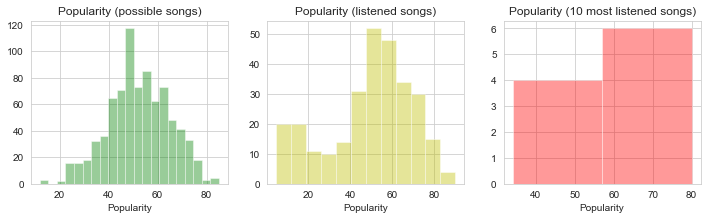

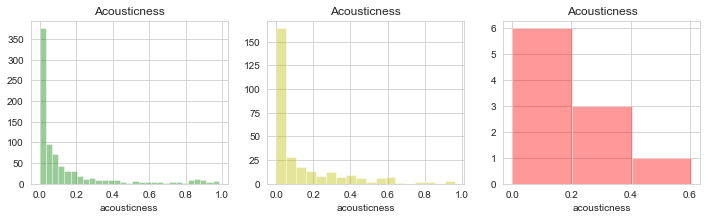

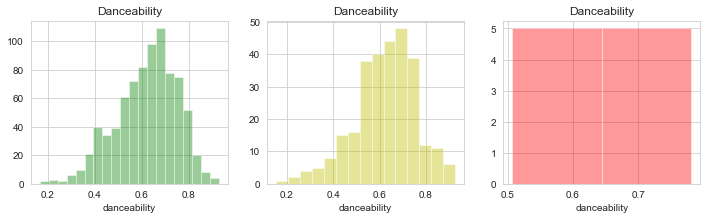

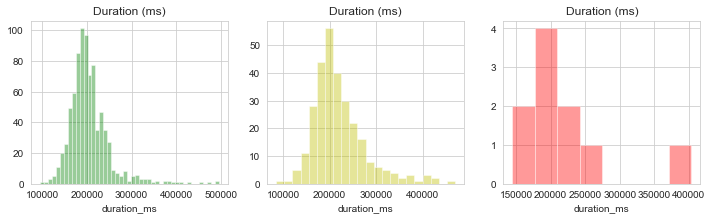

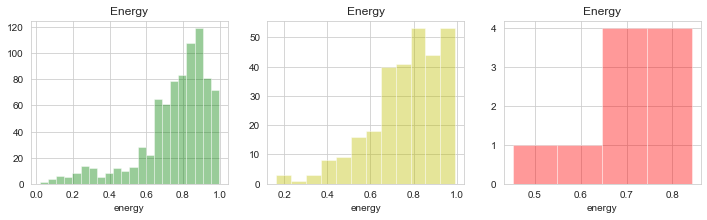

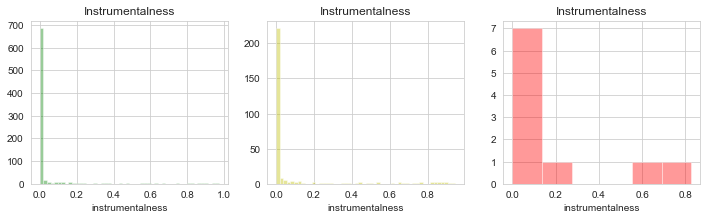

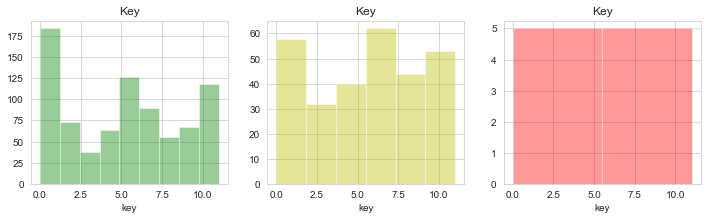

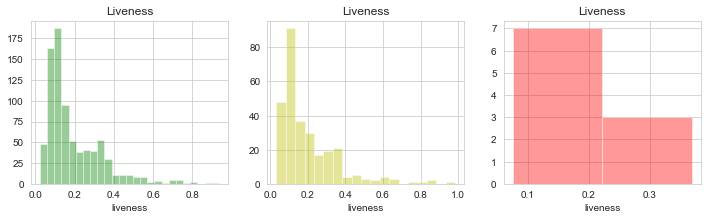

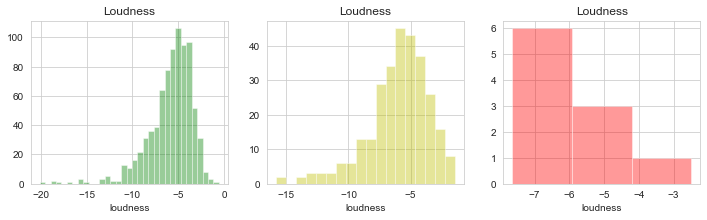

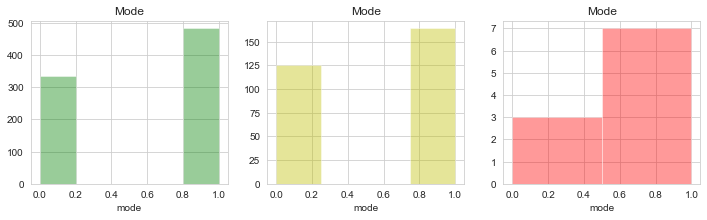

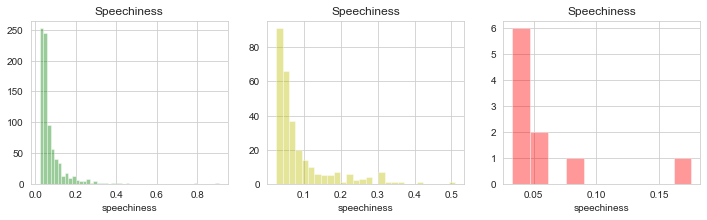

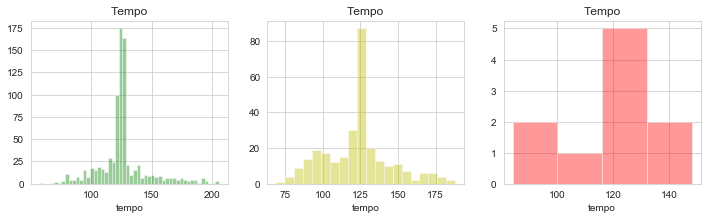

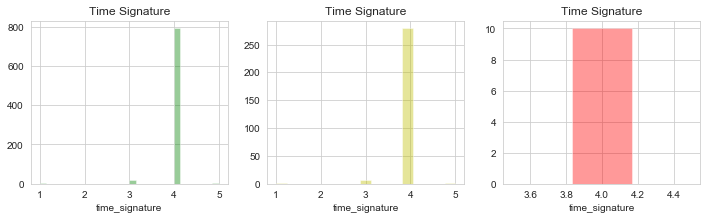

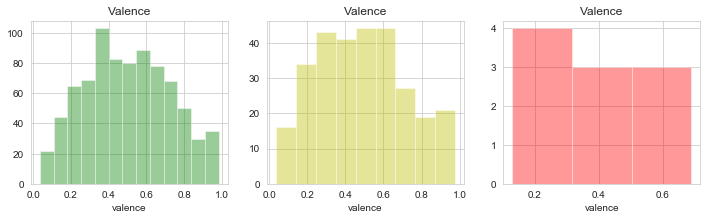

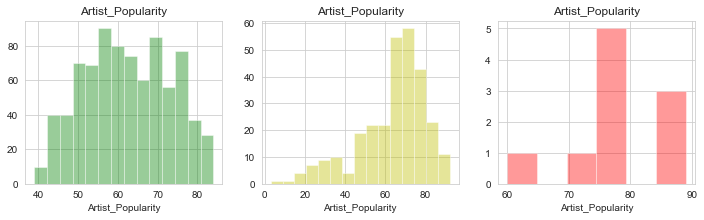

In [28]:
# Feature Statistics
fig, ax = plt.subplots(1,3,figsize=(12,3))
sns.distplot(potential_songs["Popularity"], color="g", ax=ax[0], kde=False).set_title("Popularity (possible songs)")
sns.distplot(listened_features["Popularity"], color="y", ax=ax[1], kde=False).set_title("Popularity (listened songs)")
sns.distplot(most_listened_songs["Popularity"], color="r", ax=ax[2], kde=False).set_title("Popularity (10 most listened songs)")
plt.show()

fig, ax = plt.subplots(1,3,figsize=(12,3))
sns.distplot(potential_songs["acousticness"], color="g", ax=ax[0], kde=False).set_title("Acousticness")
sns.distplot(listened_features["acousticness"], color="y", ax=ax[1], kde=False).set_title("Acousticness")
sns.distplot(most_listened_songs["acousticness"], color="r", ax=ax[2], kde=False).set_title("Acousticness")
plt.show()

fig, ax = plt.subplots(1,3,figsize=(12,3))
sns.distplot(potential_songs["danceability"], color="g", ax=ax[0], kde=False).set_title("Danceability")
sns.distplot(listened_features["danceability"], color="y", ax=ax[1], kde=False).set_title("Danceability")
sns.distplot(most_listened_songs["danceability"], color="r", ax=ax[2], kde=False).set_title("Danceability")
plt.show()

fig, ax = plt.subplots(1,3,figsize=(12,3))
sns.distplot(potential_songs["duration_ms"], color="g", ax=ax[0], kde=False).set_title("Duration (ms)")
sns.distplot(listened_features["duration_ms"], color="y", ax=ax[1], kde=False).set_title("Duration (ms)")
sns.distplot(most_listened_songs["duration_ms"], color="r", ax=ax[2], kde=False).set_title("Duration (ms)")
plt.show()

fig, ax = plt.subplots(1,3,figsize=(12,3))
sns.distplot(potential_songs["energy"], color="g", ax=ax[0], kde=False).set_title("Energy")
sns.distplot(listened_features["energy"], color="y", ax=ax[1], kde=False).set_title("Energy")
sns.distplot(most_listened_songs["energy"], color="r", ax=ax[2], kde=False).set_title("Energy")
plt.show()

fig, ax = plt.subplots(1,3,figsize=(12,3))
sns.distplot(potential_songs["instrumentalness"], color="g", ax=ax[0], kde=False).set_title("Instrumentalness")
sns.distplot(listened_features["instrumentalness"], color="y", ax=ax[1], kde=False).set_title("Instrumentalness")
sns.distplot(most_listened_songs["instrumentalness"], color="r", ax=ax[2], kde=False).set_title("Instrumentalness")
plt.show()

fig, ax = plt.subplots(1,3,figsize=(12,3))
sns.distplot(potential_songs["key"], color="g", ax=ax[0], kde=False).set_title("Key")
sns.distplot(listened_features["key"], color="y", ax=ax[1], kde=False).set_title("Key")
sns.distplot(most_listened_songs["key"], color="r", ax=ax[2], kde=False).set_title("Key")
plt.show()

fig, ax = plt.subplots(1,3,figsize=(12,3))
sns.distplot(potential_songs["liveness"], color="g", ax=ax[0], kde=False).set_title("Liveness")
sns.distplot(listened_features["liveness"], color="y", ax=ax[1], kde=False).set_title("Liveness")
sns.distplot(most_listened_songs["liveness"], color="r", ax=ax[2], kde=False).set_title("Liveness")
plt.show()

fig, ax = plt.subplots(1,3,figsize=(12,3))
sns.distplot(potential_songs["loudness"], color="g", ax=ax[0], kde=False).set_title("Loudness")
sns.distplot(listened_features["loudness"], color="y", ax=ax[1], kde=False).set_title("Loudness")
sns.distplot(most_listened_songs["loudness"], color="r", ax=ax[2], kde=False).set_title("Loudness")
plt.show()

fig, ax = plt.subplots(1,3,figsize=(12,3))
sns.distplot(potential_songs["mode"], color="g", ax=ax[0], kde=False).set_title("Mode")
sns.distplot(listened_features["mode"], color="y", ax=ax[1], kde=False).set_title("Mode")
sns.distplot(most_listened_songs["mode"], color="r", ax=ax[2], kde=False).set_title("Mode")
plt.show()

fig, ax = plt.subplots(1,3,figsize=(12,3))
sns.distplot(potential_songs["speechiness"], color="g", ax=ax[0], kde=False).set_title("Speechiness")
sns.distplot(listened_features["speechiness"], color="y", ax=ax[1], kde=False).set_title("Speechiness")
sns.distplot(most_listened_songs["speechiness"], color="r", ax=ax[2], kde=False).set_title("Speechiness")

fig, ax = plt.subplots(1,3,figsize=(12,3))
sns.distplot(potential_songs["tempo"], color="g", ax=ax[0], kde=False).set_title("Tempo")
sns.distplot(listened_features["tempo"], color="y", ax=ax[1], kde=False).set_title("Tempo")
sns.distplot(most_listened_songs["tempo"], color="r", ax=ax[2], kde=False).set_title("Tempo")
plt.show()

fig, ax = plt.subplots(1,3,figsize=(12,3))
sns.distplot(potential_songs["time_signature"], color="g", ax=ax[0], kde=False).set_title("Time Signature")
sns.distplot(listened_features["time_signature"], color="y", ax=ax[1], kde=False).set_title("Time Signature")
sns.distplot(most_listened_songs["time_signature"], color="r", ax=ax[2], kde=False).set_title("Time Signature")
plt.show()

fig, ax = plt.subplots(1,3,figsize=(12,3))
sns.distplot(potential_songs["valence"], color="g", ax=ax[0], kde=False).set_title("Valence")
sns.distplot(listened_features["valence"], color="y", ax=ax[1], kde=False).set_title("Valence")
sns.distplot(most_listened_songs["valence"], color="r", ax=ax[2], kde=False).set_title("Valence")
plt.show()

fig, ax = plt.subplots(1,3,figsize=(12,3))
sns.distplot(potential_songs["Artist_Popularity"], color="g", ax=ax[0], kde=False).set_title("Artist_Popularity")
sns.distplot(listened_features["Artist_Popularity"], color="y", ax=ax[1], kde=False).set_title("Artist_Popularity")
sns.distplot(most_listened_songs["Artist_Popularity"], color="r", ax=ax[2], kde=False).set_title("Artist_Popularity")
plt.show()

In [35]:
# Genres
genre_sum = genres(potential_songs, listened_features, most_listened_songs)

top_genres = genre_sum.sort_values(by="Top", ascending=False).loc[genre_sum["Top"] != 0]
genre_match_list = top_genres["Genre"][0:7].values.tolist() 


In [36]:
print("My most frequent listened genres, ordered by occurrence in most_listened_songs")
top_genres[0:7]

My most frequent listened genres, ordered by occurrence in most_listened_songs


,Genre,Potential,Listened,Top
3,pop,255,71,9
0,edm,428,98,8
1,tropical house,341,65,7
7,dance pop,184,40,6
2,electro house,273,67,4
4,big room,224,63,4
6,progressive electro house,190,50,4


### 3.4 Feature Engineerning

In [37]:
listened_features = listened_features.reset_index(drop=True)

# top genre, my top 7 genres this week
listened_features["genre_match"] = 0
for k in range(len(listened_features)):   
    lista = listened_features["Genre"][k]
    if any(genre in lista for genre in genre_match_list):
        listened_features["genre_match"][k] = 1
        
potential_songs["genre_match"] = 0
for k in range(len(potential_songs)):
    if len(potential_songs["Genre"][k]) != 0:
        lista =  potential_songs["Genre"][k]
        if any(genre in lista for genre in genre_match_list):
            potential_songs["genre_match"][k] = 1


# top artist as a feature my top 10 most heavily listen artiist
listened_features["Top_artist"] = 0                    
top_artist_list = top_artists["Artist"].values.tolist()
for k in range(len(listened_features)):
    if any(artist == listened_features["Artist"][k] for artist in top_artist_list):
        listened_features["Top_artist"][k] = 1

potential_songs["Top_artist"] = 0                    
top_artist_list = top_artists["Artist"].values.tolist()
for k in range(len(potential_songs)):
    if any(artist == potential_songs["Artist"][k] for artist in top_artist_list):
        potential_songs["Top_artist"][k] = 1


listened_features = listened_features.sort_values(by="Plays", ascending=False)
listened_features["Top_Song"] = 0
listened_features["Top_Song"][0:10] = 1        
        
# save these for possible extension work
listened_features.to_csv(r'songs_features_20-07-22.csv')


### 3.5 Classification

In [70]:
from sklearn.preprocessing import MinMaxScaler 
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import accuracy_score ,roc_auc_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [39]:
data = pd.read_csv("songs_features_20-07-22.csv")
data = data.drop(columns="Unnamed: 0")

# Dropping the least interesting columns and the ones that are completely arbitrary columnerna. Also dropping the top_artist column since it will have a too strong influence on the classification and lead to that only these songs get recommended
data = data.drop(columns=["Name","Id","key","mode","time_signature","Artist","Genre","Plays","Top_artist"], axis = 1)
data.shape

(289, 14)

(14.0, 0.0)

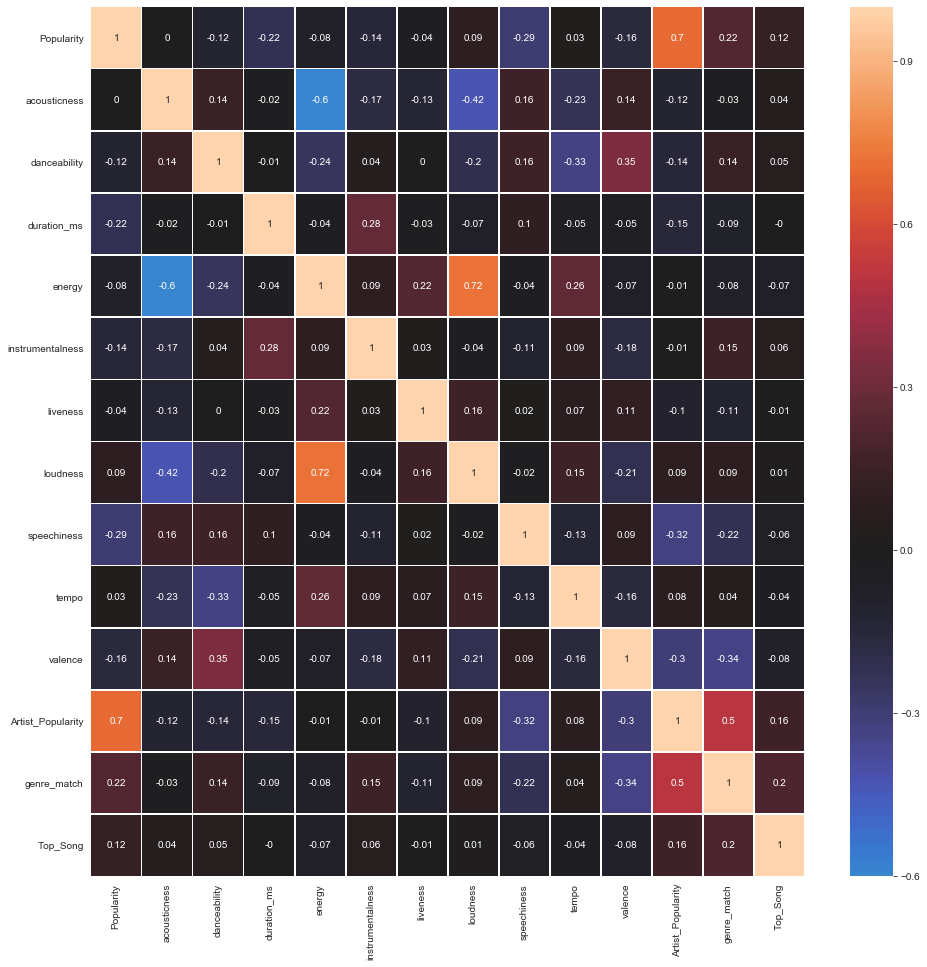

In [40]:
# Correlation matrix for feature selection
plt.figure(figsize=(16,16))
corr = sns.heatmap(np.round(data.corr(),2),annot=True, center=0,linewidths=.5)

# There are strange cut offs for the highest/lowest rows, fixed with the following 
bottom, top = corr.get_ylim()
corr.set_ylim(bottom + 0.5, top - 0.5)

In [41]:
# In preperation for the models I scale all variables
scaler = MinMaxScaler()

data_scaled = pd.DataFrame(scaler.fit_transform(data),columns = data.columns)

data_scaled_x = data_scaled.drop(columns=["Top_Song"])

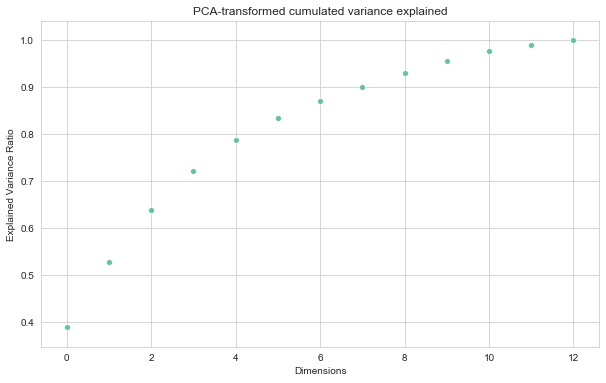

In [42]:
# In trying to reduce complexity of the models I want to use fewer variables. By constructing PCAs I want to see how much of the varience is explained by variables used.  
pca=PCA()

pca.fit(data_scaled_x)
data_pca=pca.transform(data_scaled_x)
el=np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=el,color=sns.color_palette("Set2")[0])
ax.set(xlabel='Dimensions', ylabel='Explained Variance Ratio')
plt.title("PCA-transformed cumulated variance explained")
plt.show()


It turns out we want to use as many columns as possible. My initial idea was to choose the five or so variables with the highest correlation with "Top_Song" but that would give a less clear picture. Also all varibales have quite similar magnitude of correlation so the decion of which to choose could easily become misleading.


In [43]:
# Unbalanced dataset

data_y = data_scaled["Top_Song"]
data_y.value_counts()

0.0    279
1.0     10
Name: Top_Song, dtype: int64

In [44]:
# This would create problems for the fitting of the prediction model. Becouse of this I'm oversampling the Top Songs using SMOTE 
oversample = SMOTE()
smote_x, smote_y = oversample.fit_resample(data_scaled_x, data_y)


In [45]:
# Splitting the dataset into 70/30 train/validation set
x_train_70, x_test_30, y_train_70, y_test_30 = train_test_split(smote_x, smote_y, test_size = 0.30, random_state = 42)


In [46]:
# Hyperparameter tuning for RandomForest
# Create a parameter grid to sample from during fitting

# Parameters:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [78]:
# Use the random grid to narrow down the possible best hyperparameters
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(x_train_70, y_train_70)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.6min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [79]:
# Found best parameters
rf_random.best_params_


{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': True}

In [ ]:
# Find the specific best parameters by searching every combination close to our earlier findings

# Create a new parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [20,30,40],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [1, 2, 3],
    'n_estimators': [500, 1000,2000]
}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(x_train_70, y_train_70)

grid_search.best_params_


Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   25.0s


In [74]:
# Validation of RF 
# The most important thing to get the positives right, the consequences of FN isn't that bad and to get an extra song with FP would also be okay
# Therefore I'm using precision as a valueble metric
# Precision = TP/(TP+FP)

rf_best = RandomForestClassifier(n_estimators = 200, min_samples_split = 2,
                                 min_samples_leaf = 1, max_features = 1,
                                 max_depth = None, bootstrap = False)

rf_best.fit(x_train_70, y_train_70)
Y_pred_30_best = rf_best.predict(x_test_30)

print('Random Forest Model Validation result:\n')
print('Accuracy Score: {}\n\nPrecision Score: {}\n\nConfusion Matrix:\n {}\n\nAUC Score: {}'
      .format(accuracy_score(y_test_30,Y_pred_30_best), precision_score(y_test_30,Y_pred_30_best),confusion_matrix(y_test_30,Y_pred_30_best), roc_auc_score(y_test_30,Y_pred_30_best)))


Random Forest Model Validation result:

Accuracy Score: 0.9940476190476191

Precision Score: 0.9876543209876543

Confusion Matrix:
 [[87  1]
 [ 0 80]]

AUC Score: 0.9943181818181819


In [72]:
# Comparison with the base classifier
rf_base = RandomForestClassifier()


rf_base.fit(x_train_70, y_train_70)
Y_pred_30_base = rf_base.predict(x_test_30)

print('Base Random Forest Model Validation result:\n')
print('Accuracy Score: {}\n\nPrecision Score: {}\n\nConfusion Matrix:\n {}\n\nAUC Score: {}'
      .format(accuracy_score(y_test_30,Y_pred_30_base), precision_score(y_test_30,Y_pred_30_base),confusion_matrix(y_test_30,Y_pred_30_base), roc_auc_score(y_test_30,Y_pred_30_base)))

Base Random Forest Model Validation result:

Accuracy Score: 0.9821428571428571

Precision Score: 0.963855421686747

Confusion Matrix:
 [[85  3]
 [ 0 80]]

AUC Score: 0.9829545454545455


The base model gets quite good results as well, but the optimized model recives a 3.5% higher precision score which is nice.

In [77]:
X_test = potential_songs.drop(columns=['Name', 'Id',
       'key','mode', 'time_signature',"Genre","Artist","Top_artist"]).astype(float)
    
X_test = pd.DataFrame(scaler.fit_transform(X_test),columns = X_test.columns)

Y_pred_RF = rf_best.predict(X_test)


recommended_songs = pd.DataFrame(index=potential_songs.index)
recommended_songs["Name"] = potential_songs["Name"]
recommended_songs["id"] = potential_songs["Id"]
recommended_songs["Artist"] = potential_songs["Artist"]
recommended_songs["RF_rec"] = Y_pred_RF
recommended_songs = recommended_songs[recommended_songs.RF_rec != 0]
recommended_songs = recommended_songs.reset_index(drop=True)
recommended_songs = recommended_songs.drop(columns=["RF_rec"])
recommended_songs

,Name,id,Artist
0,Sad (feat. Afrojack),4ESPuOrSsRcBISzcMlzmY5,Afrojack
1,I'm Just Feelin' (Du Du Du),73ThEGwF5i9GrsXXGyZBRa,Martin Jensen
2,Nobody,0Qew3aYvQPGPjfL7gbe6x1,Martin Jensen
3,Don't Cry For Me (with Jason Derulo),5qNYK53oA91QaIC9u7m0oK,Martin Jensen
4,Post Malone (feat. RANI),36orMWv2PgvnzXsd5CJ0yL,Sam Feldt
5,Way Back Home (feat. Conor Maynard) - Sam Feld...,1ZLrDPgR7mvuTco3rQK8Pk,Sam Feldt
6,Hold Me Close (feat. Ella Henderson),24aN8j7dBw0FxxKUBlCtd6,Sam Feldt
7,In Your Eyes (feat. Alida),61ZM92T2zaXIVsqncThQzC,Robin Schulz
8,No Promises (feat. Demi Lovato),1louJpMmzEicAn7lzDalPW,Cheat Codes
9,Only You (with Little Mix),54l9GJGQ1UCFKe2tzt1Vxt,Cheat Codes


In [76]:
# To CSV for possible future work, overall I'm quite happy with these recomendations
recommended_songs.to_csv(r'reco_200723.csv')
